
_________

**Название проекта.**

Сервис по определению рыночной стоимости автомобилей.

_________

**Описание проекта.**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов, в котором можно определить рыночную стоимость автомобиля на основе его технических характеристик, комплектации и цен других автомобилей. Необходимо построить модель машинного обучения, которая сможет точно предсказывать стоимость автомобиля. Заказчик акцентирует внимание на следующих критериях: качество предсказания (RMSE < 2500), время обучения модели и время предсказания.
__________

**Задачи проекта.**

1. Загрузить и изучить данные из файла `/datasets/autos.csv`.
2. Провести предобработку данных: заполнить пропущенные значения, обработать аномалии, удалить неинформативные признаки.
3. Подготовить выборки для обучения моделей.
4. Обучить различные модели, включая LightGBM и как минимум одну модель, не основанную на градиентном бустинге, с разными гиперпараметрами.
5. Оценить модели по критериям: время обучения, время предсказания и качество предсказания (метрика RMSE).
6. Выбрать лучшую модель на основе критериев заказчика и проверить её качество на тестовой выборке.

____________

**Исходные данные.**

Данные находятся в файле `/datasets/autos.csv`.  
**Признаки:**  
- `DateCrawled` — дата скачивания анкеты из базы  
- `VehicleType` — тип автомобильного кузова  
- `RegistrationYear` — год регистрации автомобиля  
- `Gearbox` — тип коробки передач  
- `Power` — мощность (л. с.)  
- `Model` — модель автомобиля  
- `Kilometer` — пробег (км)  
- `RegistrationMonth` — месяц регистрации автомобиля  
- `FuelType` — тип топлива  
- `Brand` — марка автомобиля  
- `Repaired` — была машина в ремонте или нет  
- `DateCreated` — дата создания анкеты  
- `NumberOfPictures` — количество фотографий автомобиля  
- `PostalCode` — почтовый индекс владельца анкеты  
- `LastSeen` — дата последней активности пользователя  

**Целевой признак:**  
- `Price` — цена автомобиля (евро)

____________

**Данное исследование разделим на несколько частей.**



- [**Шаг 1. Загрузка и изучение данных.**](#section1)
  - [Загрузка данных.](#section1.1)
  - [Изучение данных.](#section1.2)
  - [Промежутончый вывод.](#section1.3)


- [**Шаг 2. Предобработка данных.**](#section2)
  - [Названия столбцов.](#section2.1)
  - [Обработка пропусков.](#section2.2)
  - [Поиск дубликатов.](#section2.3)
  - [Тип данных.](#section2.4)
  - [Промежуточный вывод.](#section2.5)


- [**Шаг 3. Иследовательский анализ данных.**](#section3)
  - [Исследовательский анализ признаков.](#section3.1)
  - [Промжуточный вывод.](#section3.2)


-  [**Шаг 4. Подготовка данных.**](#section4)
   - [Корреляционный анализ признаков.](#section4.1)
   - [Промежуточный вывод.](#section4.2)


-  [**Шаг 5. Обучение моделей.**](#section5)
   - [Подбор гиперпараметров.](#section5.1)
   - [CatBoost.](#section5.2)
   - [LightGBM.](#section5.3)
   - [Выбор модели.](#section5.4) 


-  [**Шаг 6. Итоговый вывод.**](#section6)


---------


In [1]:
!pip install lightgbm -q
!pip install catboost -q
!pip install phik -q
!pip install optuna -q
!pip install optuna-integration[sklearn] -q
!pip install -Uq scikit-learn

In [2]:
import pandas as pd

import matplotlib.pylab as plt
import seaborn as sns
from phik import phik_matrix

import os
import re
import numpy as np

from optuna.integration import OptunaSearchCV
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer

import lightgbm as lgb
from catboost import CatBoostRegressor

<a id="section1"></a>
### Загрузка и изучение данных.

<a id="section1.1"></a>
#### Загрузка данных.

In [3]:

auto_pth1 = '/Users/ruslanminacov/Downloads/autos.csv'
auto_pth2 = 'https://code.s3.yandex.net/datasets/autos.csv'
if os.path.exists(auto_pth1):
    auto = pd.read_csv(auto_pth1)
elif auto_pth2.startswith('http'):
    try:
        auto = pd.read_csv(auto_pth2)
    except Exception as e:
        print(f"Ошибка при загрузке y_test из URL: {e}")
else:
    print('Something is wrong with test_target_job_satisfaction_rate.csv')


if 'auto' in locals():
    print(f"auto loaded with shape: {auto.shape}")

auto loaded with shape: (354369, 16)


<a id="section1.2"></a>
#### Изучение данных 

In [4]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
auto.head(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<a id="section1.3"></a>
#### Промежуточный вывод.


На этапе загрузки и изучения данных был успешно загружен датасет из файла `autos.csv`, содержащий 354,369 записей и 16 столбцов. Датасет включает признаки, описывающие технические характеристики автомобилей, такие как тип кузова, год регистрации, мощность, пробег, а также информацию о цене (целевой признак) и дополнительные характеристики, такие как тип топлива, марка и наличие ремонта. 

В ходе изучения данных выявлено, что:
- Датасет содержит пропущенные значения в столбцах `VehicleType` (37,490 пропусков), `Gearbox` (19,833 пропуска), `Model` (19,705 пропусков), `FuelType` (32,895 пропусков) и `Repaired` (71,154 пропуска). Эти пропуски требуют дальнейшей обработки.
- Типы данных соответствуют ожидаемым: числовые столбцы (`Price`, `RegistrationYear`, `Power`, `Kilometer`, `RegistrationMonth`, `NumberOfPictures`, `PostalCode`) имеют тип `int64`, а категориальные и временные признаки (`DateCrawled`, `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`, `Repaired`, `DateCreated`, `LastSeen`) имеют тип `object`.
- Предварительный просмотр первых строк данных показывает, что некоторые признаки, такие как `NumberOfPictures`, могут быть неинформативными (например, все значения в первых строках равны 0), что требует проверки на этапе предобработки.


<a id="section2"></a>
### Предобработка данных.

Перед предобработкой данных удалим столбцы, которые никак не относятся к предсказанию стоимости машины ( `date_created`, `number_of_pictures`, `postal_code`, `last_seen`, `date_crawled` относятся к активности пользователя и никак не влияют на состояние машины).  Перед этим сравним максимальные значения даты регистрации и DateCrawled, которые должны совпадать:


In [6]:
auto['DateCrawled'] = pd.to_datetime(auto['DateCrawled'], errors='coerce')
auto = auto[(auto['RegistrationYear'] <= auto['DateCrawled'].dt.year)]

In [7]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339839 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        339839 non-null  datetime64[ns]
 1   Price              339839 non-null  int64         
 2   VehicleType        316859 non-null  object        
 3   RegistrationYear   339839 non-null  int64         
 4   Gearbox            321873 non-null  object        
 5   Power              339839 non-null  int64         
 6   Model              322181 non-null  object        
 7   Kilometer          339839 non-null  int64         
 8   RegistrationMonth  339839 non-null  int64         
 9   FuelType           312538 non-null  object        
 10  Brand              339839 non-null  object        
 11  Repaired           274984 non-null  object        
 12  DateCreated        339839 non-null  object        
 13  NumberOfPictures   339839 non-null  int64   

In [8]:
auto_client_info = auto[['DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCrawled']]
auto = auto.drop(columns=['DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCrawled'])

In [9]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339839 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              339839 non-null  int64 
 1   VehicleType        316859 non-null  object
 2   RegistrationYear   339839 non-null  int64 
 3   Gearbox            321873 non-null  object
 4   Power              339839 non-null  int64 
 5   Model              322181 non-null  object
 6   Kilometer          339839 non-null  int64 
 7   RegistrationMonth  339839 non-null  int64 
 8   FuelType           312538 non-null  object
 9   Brand              339839 non-null  object
 10  Repaired           274984 non-null  object
dtypes: int64(5), object(6)
memory usage: 31.1+ MB


<a id="section2.1"></a>
#### Названия столбцов 

Приведем названия столбцов к змеинному регистру:

In [10]:
def to_snake_case(name):
    name = re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower()
    return name

auto.columns = [to_snake_case(col) for col in auto.columns]

In [11]:
auto.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

<a id="section2.2"></a>
#### Обработка пропусков.

Вынесем пропуски в столбце `model` в отдельный датафрейм и удалим их из исходного, потому что модель машины один из ключевых факторов оценки стоимости машины.

In [12]:
auto_no_model = auto[auto['model'].isna()]
auto = auto[~auto['model'].isna()].reset_index(drop=True)

In [13]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322181 entries, 0 to 322180
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               322181 non-null  int64 
 1   vehicle_type        303983 non-null  object
 2   registration_year   322181 non-null  int64 
 3   gearbox             307929 non-null  object
 4   power               322181 non-null  int64 
 5   model               322181 non-null  object
 6   kilometer           322181 non-null  int64 
 7   registration_month  322181 non-null  int64 
 8   fuel_type           300971 non-null  object
 9   brand               322181 non-null  object
 10  repaired            265419 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.0+ MB


Пропуски в столбцах `vehicle_type`, `gearbox` и `fuel_type` заполним модой сгрупированных столбцов brand и model.  

In [14]:
def fill_na_with_mode(target_column):
    auto[target_column] = auto.groupby(['model', 'brand'])[target_column].transform(
        lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown')
    )
    return auto


auto = fill_na_with_mode('vehicle_type')
auto = fill_na_with_mode('gearbox')
auto = fill_na_with_mode('fuel_type')

In [15]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322181 entries, 0 to 322180
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               322181 non-null  int64 
 1   vehicle_type        322181 non-null  object
 2   registration_year   322181 non-null  int64 
 3   gearbox             322181 non-null  object
 4   power               322181 non-null  int64 
 5   model               322181 non-null  object
 6   kilometer           322181 non-null  int64 
 7   registration_month  322181 non-null  int64 
 8   fuel_type           322181 non-null  object
 9   brand               322181 non-null  object
 10  repaired            265419 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.0+ MB


Пропуски в столбце `repaired` заменим на значение `unknown`, т.к. пропусков в этом столбце большое количество, а признак потенциально внесет большой вклад в предсказание будущих моделей.

In [16]:
auto['repaired'] = auto['repaired'].fillna('unknown')

Удалим неявные дубликаты в столбце `fuel_type`,  кнкретно значения `petrol` и `gasoline`.

In [18]:
auto['fuel_type'] = auto['fuel_type'].replace({'petrol':'gasoline'})

In [52]:
auto['fuel_type'].unique()

array(['gasoline', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

In [19]:
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322181 entries, 0 to 322180
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               322181 non-null  int64 
 1   vehicle_type        322181 non-null  object
 2   registration_year   322181 non-null  int64 
 3   gearbox             322181 non-null  object
 4   power               322181 non-null  int64 
 5   model               322181 non-null  object
 6   kilometer           322181 non-null  int64 
 7   registration_month  322181 non-null  int64 
 8   fuel_type           322181 non-null  object
 9   brand               322181 non-null  object
 10  repaired            322181 non-null  object
dtypes: int64(5), object(6)
memory usage: 27.0+ MB


<a id="section2.3"></a>
#### Поиск дубликатов.

In [20]:
auto.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'repaired'],
      dtype='object')

In [21]:
columns= ['price', 'vehicle_type', 'gearbox',
       'power', 'model', 'kilometer', 'fuel_type',
       'brand', 'repaired']
auto[auto[columns].duplicated()]

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
475,1000,small,2001,manual,75,golf,150000,1,gasoline,volkswagen,no
534,0,sedan,1997,manual,0,3er,150000,0,gasoline,bmw,unknown
878,0,sedan,1990,manual,0,3er,150000,0,gasoline,bmw,unknown
1011,950,small,1999,manual,60,polo,150000,3,gasoline,volkswagen,no
1075,250,small,1997,manual,0,twingo,150000,0,gasoline,renault,yes
...,...,...,...,...,...,...,...,...,...,...,...
322168,4400,sedan,2008,manual,105,leon,150000,7,gasoline,seat,no
322171,1490,small,1998,manual,50,lupo,150000,9,gasoline,volkswagen,no
322172,7900,sedan,2010,manual,140,golf,150000,7,gasoline,volkswagen,no
322174,5250,wagon,2016,auto,150,159,150000,12,gasoline,alfa_romeo,no


In [22]:
auto = auto.drop_duplicates(subset=columns, keep='first').reset_index(drop=True)
print(f"Размер датафрейма после удаления дубликатов: {auto.shape}")

Размер датафрейма после удаления дубликатов: (238970, 11)


<a id="section2.4"></a>
#### Тип данных.

In [23]:
auto[['price', 'registration_year', 'power', 'kilometer', 'registration_month',]] = \
            auto[['price', 'registration_year', 'power', 'kilometer', 'registration_month',]].astype('int32')
auto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238970 entries, 0 to 238969
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               238970 non-null  int32 
 1   vehicle_type        238970 non-null  object
 2   registration_year   238970 non-null  int32 
 3   gearbox             238970 non-null  object
 4   power               238970 non-null  int32 
 5   model               238970 non-null  object
 6   kilometer           238970 non-null  int32 
 7   registration_month  238970 non-null  int32 
 8   fuel_type           238970 non-null  object
 9   brand               238970 non-null  object
 10  repaired            238970 non-null  object
dtypes: int32(5), object(6)
memory usage: 15.5+ MB


<a id="section2.5"></a>
#### Промежуточный вывод.


- **Удаление столбцов**: Убраны `date_created`, `number_of_pictures`, `postal_code`, `last_seen`, `date_crawled` как нерелевантные для стоимости машины. Осталось 11 столбцов.
- **Названия столбцов**: Приведены к змеинному регистру (например, `vehicle_type`).
- **Обработка пропусков**: Пропуски в `model` удалены (19 705 записей в `auto_no_model`), в `vehicle_type`, `gearbox`, `fuel_type` заполнены модой по `model` и `brand`, в `repaired` заменены на `'unknown'`.
- **Удаление дубликатов**: Убрано 83 936 дубликатов, размер датафрейма сократился до 250 728 записей.
- **Тип данных**: Числовые столбцы (`price`, `registration_year`, `power`, `kilometer`, `registration_month`) преобразованы в `int32`, снизив память с 28.1+ MB до 16.3+ MB.

**Итог:** Данные очищены, оптимизированы и готовы к анализу.

### Иследовательский анализ данных.

In [24]:
def histo(column, bins_count):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    auto[column].plot(kind='hist', bins=bins_count, color='blue', edgecolor='black', ax=ax1)
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    ax1.set_title(f'Гистограмма {column}')
    ax1.set_ylabel('Количество значений')
    ax1.set_xlabel(column)

    auto.boxplot(column=column, ax=ax2, vert=True)
    ax2.set_title(f'Boxplot {column}')
    ax2.set_ylabel('Значения')

    
    plt.tight_layout()


    plt.show()

def bar(df, column):
   
        ax = df[column].value_counts(ascending=True).plot(kind='barh', figsize=(10,4), edgecolor='black')

        for rect in ax.patches:
            ax.annotate(f'{int(rect.get_width())}', 
                        (rect.get_width() + 2 , rect.get_y() + rect.get_height() / 2),
                        va='center')

        plt.grid(axis='x', linestyle='--', alpha=0.7)    
        plt.title(f'Линейчатый график {column}')
        plt.ylabel(column)
        plt.xlabel('Количество')

        plt.show()

<a id="section3.1"></a>
#### Исследовательский анализ признаков.

**Признак `price` (целевой).**

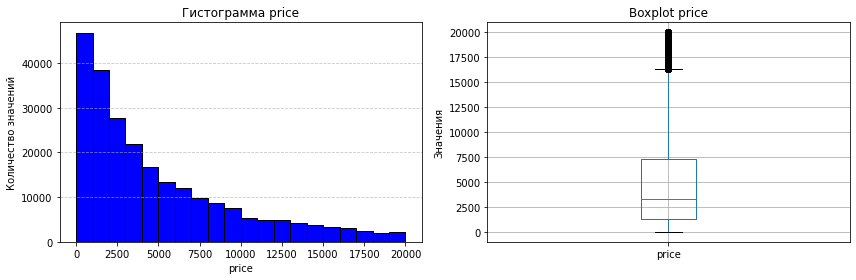

In [25]:
histo('price', 20)

Удалим автомобили с ценой менее 1000, потому что такие значения данного признака явно являются выбросами.

In [26]:
auto = auto[auto['price'] >= 1000]

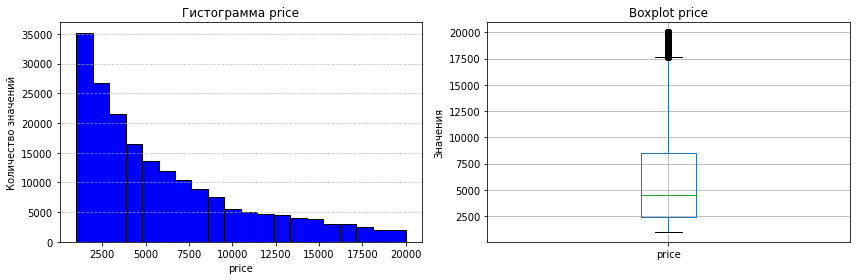

In [27]:
histo('price', 20)

- **Распределение:** Цены автомобилей имеют распределение отличное от нормального с положительной асимметрией. Большинство значений сосредоточено в нижнем диапазоне (1000–10 000), с редкими, но значительными значениями до 20 000.
- **Центр и разброс:** Медиана около 3000, с межквартильным размахом 1500–7000. Полный диапазон от 1000 до 20 000, с выбросами выше 15 000.

**Признак `registration_year`.**

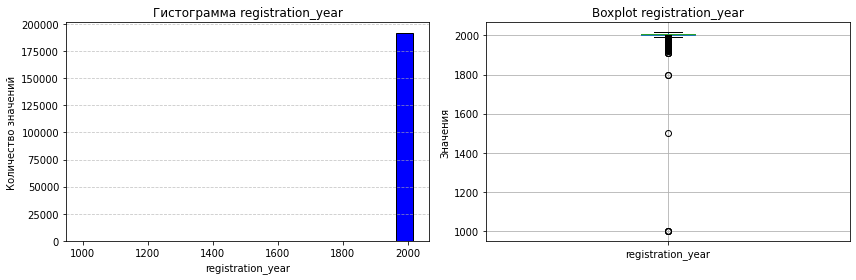

In [28]:
histo('registration_year', 20)

Почистим данные от выбросов, машины зарегестрированные раньше 1980 года и после 2025 года явно являются выбросами.

In [29]:
auto = auto[(auto['registration_year']<=2025)&(auto['registration_year'] >= 1980)]

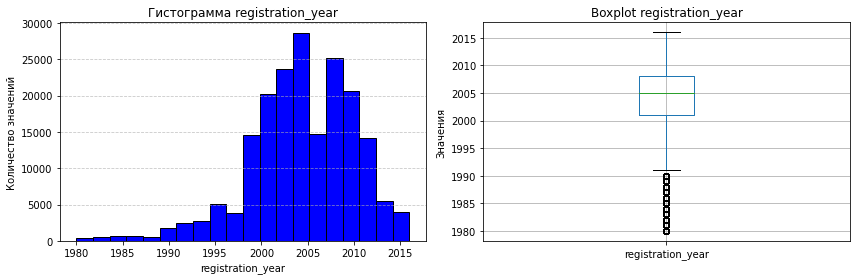

In [30]:
histo('registration_year', 20)

- **Распределение**: Годы регистрации имеют отрицательную асимметрию с пиком в диапазоне 2000–2010 годов, и второстепенным пиком в 2015 году. Распределение не является нормальным, а скорее демонстрирует мультимодальность с несколькими локальными пиками.
- **Центр и разброс**: Медиана находится около 2004 года, с межквартильным размахом примерно 2000–2008. Полный диапазон от 1980 до 2016, с редкими значениями до 1990 и после 2013.


**Признак `power`.**

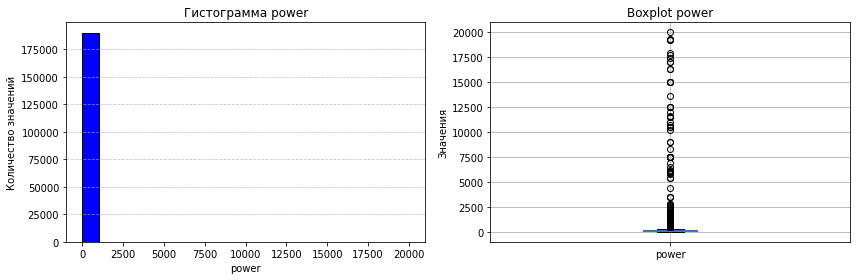

In [31]:
histo('power', 20)

Почистим данные от выбросов, машины c количеством лошадиных сил больше 1000 и меньше 20 явно являются выбросами.



In [32]:
auto = auto[(auto['power'] <= 1000)&(auto['power'] > 20)]

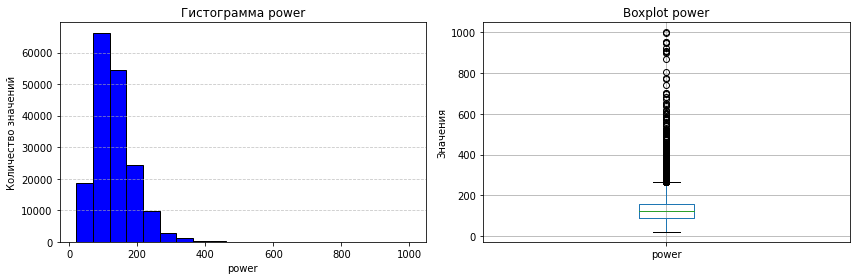

In [33]:
histo('power', 20)

- **Распределение**: Мощность (`power`) демонстрирует положительную асимметрию с пиком в диапазоне 20–200, с резким спадом после 400. Распределение имеет один основной пик и напоминает экспоненциальное с длинным хвостом.
- **Центр и разброс**: Медиана находится около 100, с межквартильным размахом примерно 0–250. Полный диапазон от 40 до 1000, с редкими значениями выше 400.

**Признак `kilometer`.**

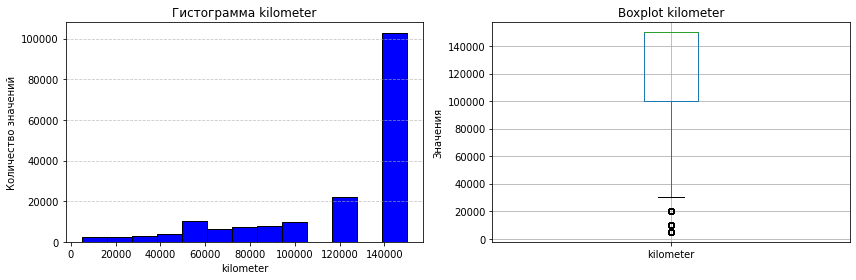

In [34]:
histo('kilometer', len(auto['kilometer'].unique()))

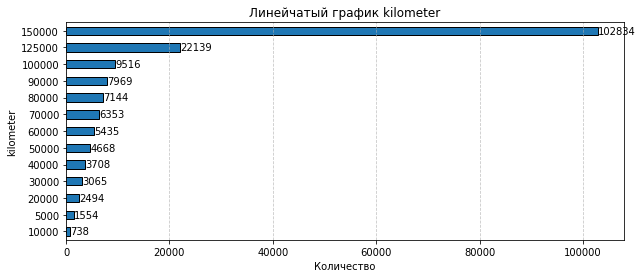

In [35]:
bar(auto,'kilometer')

 **Признак `vehicle_type`.**

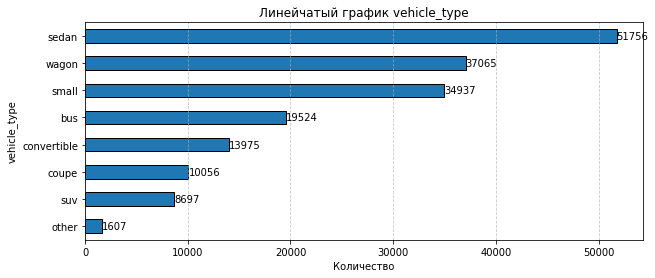

In [36]:
bar(auto, 'vehicle_type')

Наибольшее количество автомобилей приходится на седаны (66 258), что делает их наиболее распространенным типом. На втором месте — small (50 355), за ним следуют wagon (46 404) и bus (22 706). Меньше всего представлены другие типы (other) с 2 146 случаями, а также suv (9 198), coupe (12 014) и convertible (15 029), что указывает на их меньшую популярность.

**Признак `gearbox`.**

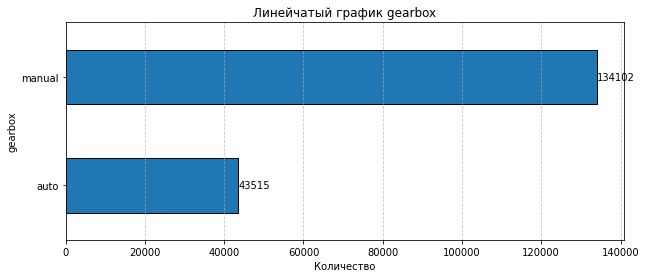

In [37]:
bar(auto, 'gearbox')

Значение для `manual` составляет 174 727, что значительно превышает значение для `auto`, равное 49 383. Это указывает на то, что механические коробки передач доминируют в данных, в то время как автоматическиевстречают ся реже, примерно в 3,5 раза.

**Признак `brand` и `model`.**

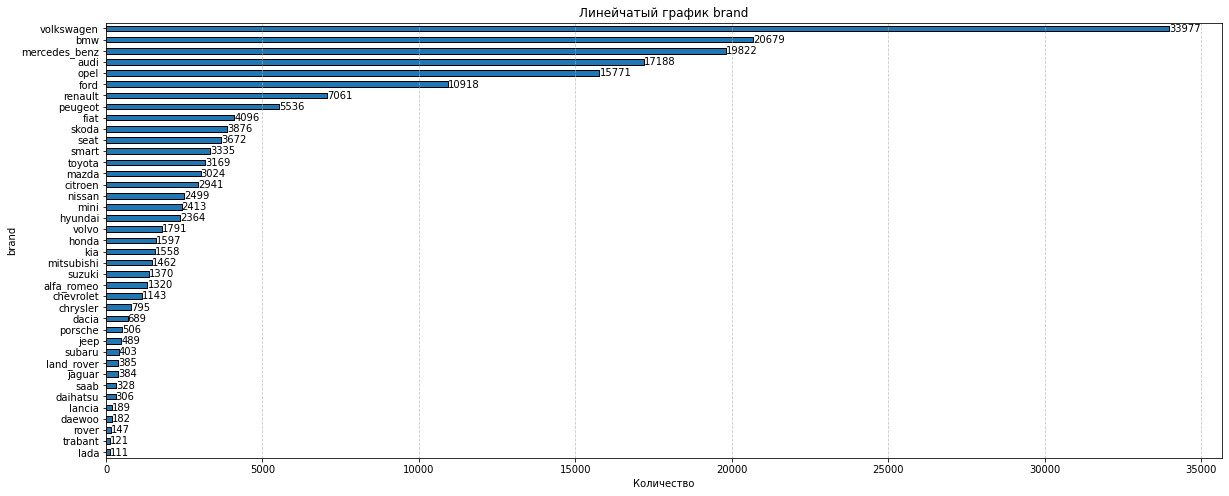

In [38]:

            ax = auto['brand'].value_counts(ascending=True).plot(kind='barh', figsize=(20,8), edgecolor='black')

            for rect in ax.patches:
                ax.annotate(f'{int(rect.get_width())}', 
                            (rect.get_width() + 2 , rect.get_y() + rect.get_height() / 2),
                            va='center')

            plt.grid(axis='x', linestyle='--', alpha=0.7)    
            plt.title(f'Линейчатый график brand')
            plt.ylabel('brand')
            plt.xlabel('Количество')

            plt.show()

Наиболее частым брендом с большим отрывом является `Volkswagen` с показателем в 42 867 автомобилей. За ним следуют `BMW` с 23 657 случаями, `Mercedes-Benz` с 22 300 и `Audi` с 20 050, что указывает на значительную популярность этих массовых немецких брендов. `Ford` пятая по популярности мрака с 15 895, `Renault` занимает шестую позицию с 11 086 случаями, за ним следуют `Peugeot` (6 713), `Fiat` (6 071). Этот сегмент включает бренды, которые имеют стабильное, но менее массовое присутствие. Остальные марки в наборе данных представлены менее чем 5000 автомобилей.

Для кажого бренда выведем модели машин:

Автомобильная марка jeep:


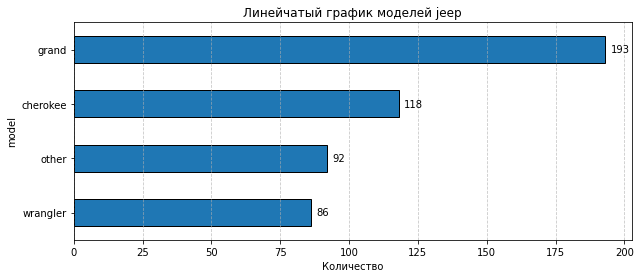

Автомобильная марка volkswagen:


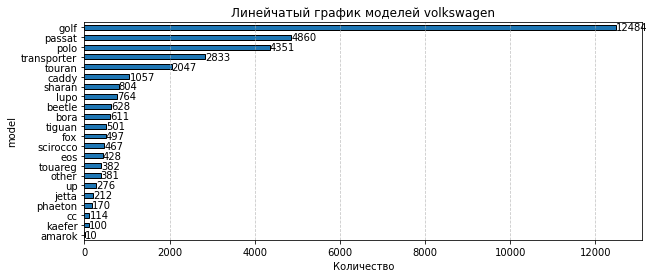

Автомобильная марка skoda:


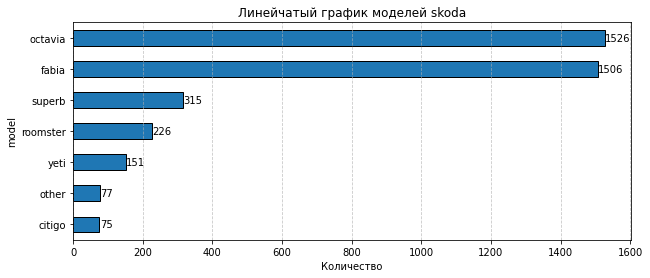

Автомобильная марка peugeot:


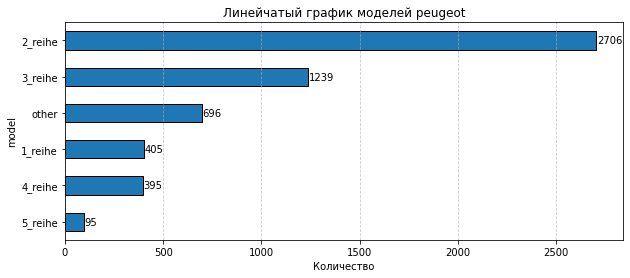

Автомобильная марка ford:


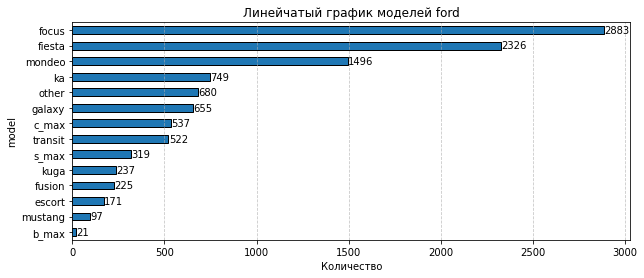

Автомобильная марка mazda:


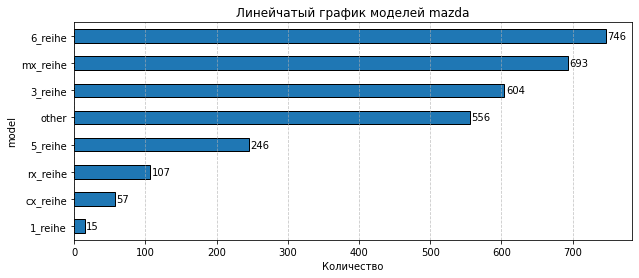

Автомобильная марка nissan:


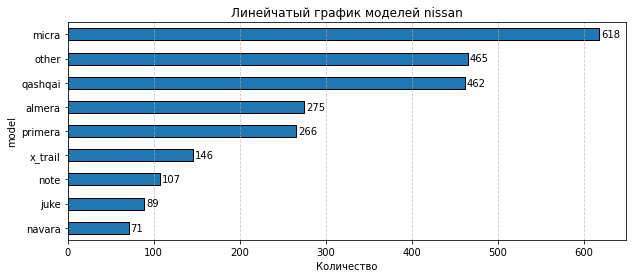

Автомобильная марка renault:


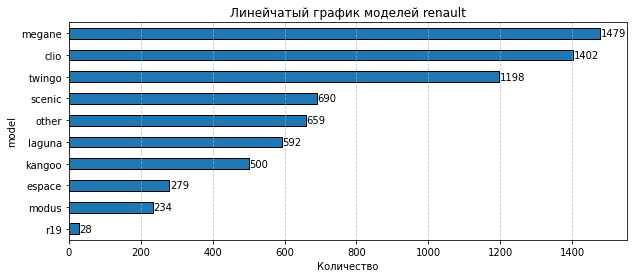

Автомобильная марка mercedes_benz:


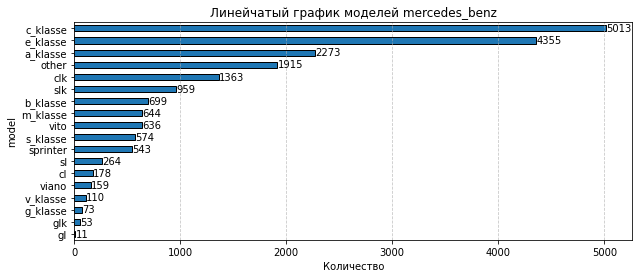

Автомобильная марка bmw:


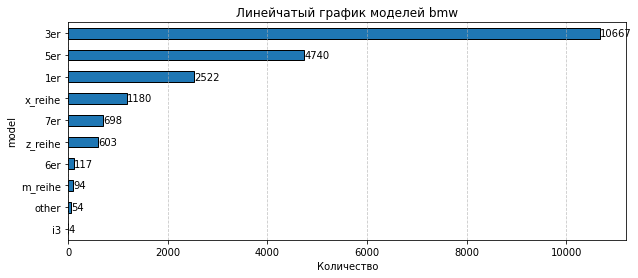

Автомобильная марка honda:


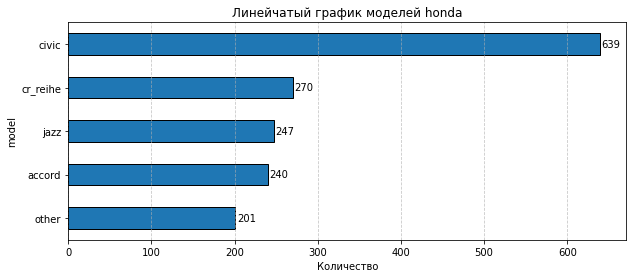

Автомобильная марка opel:


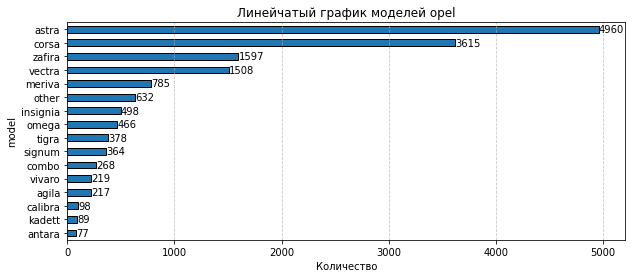

Автомобильная марка mini:


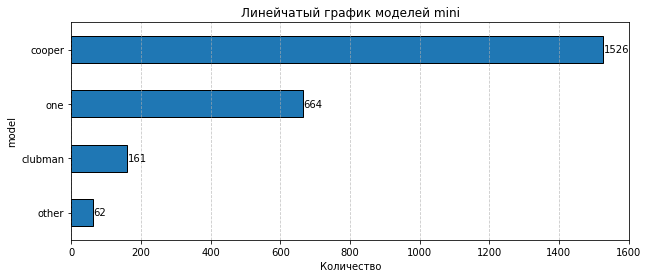

Автомобильная марка smart:


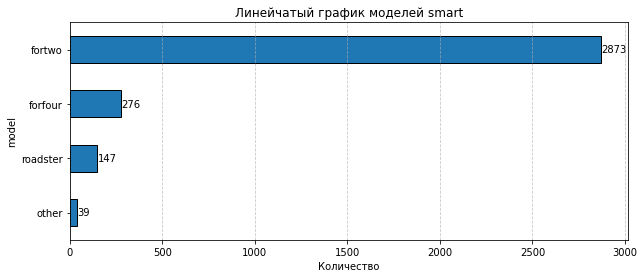

Автомобильная марка hyundai:


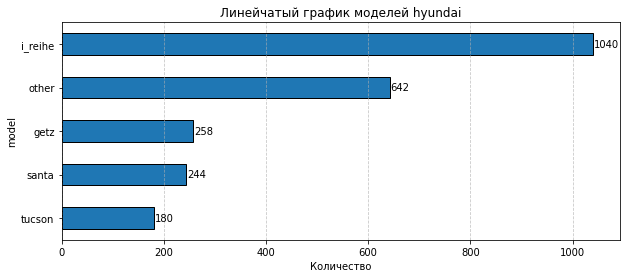

Автомобильная марка audi:


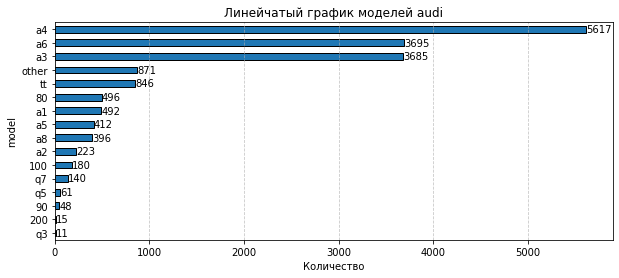

Автомобильная марка subaru:


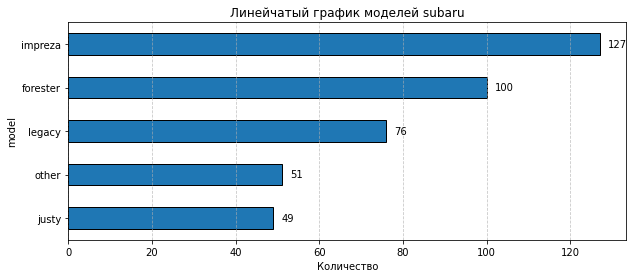

Автомобильная марка volvo:


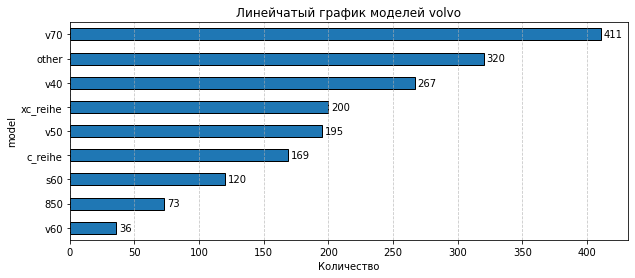

Автомобильная марка mitsubishi:


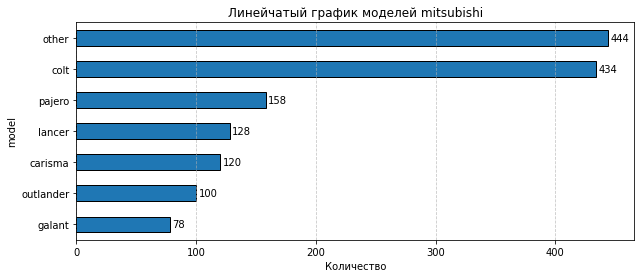

Автомобильная марка alfa_romeo:


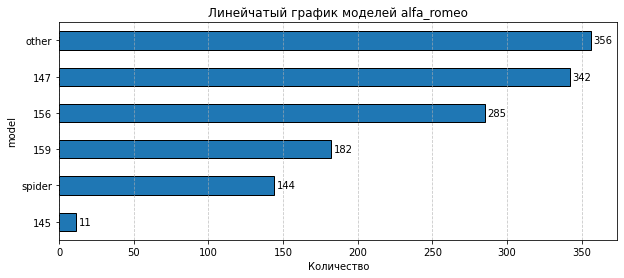

Автомобильная марка kia:


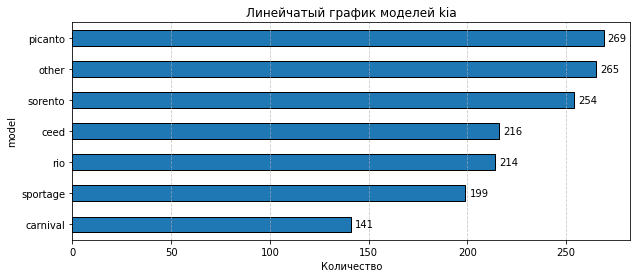

Автомобильная марка seat:


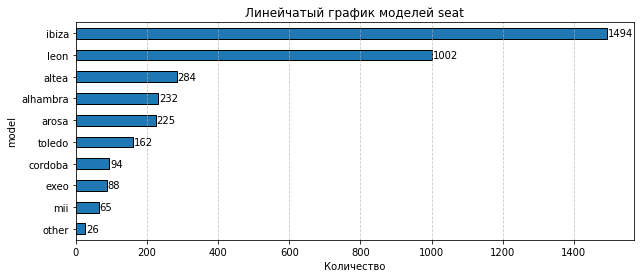

Автомобильная марка suzuki:


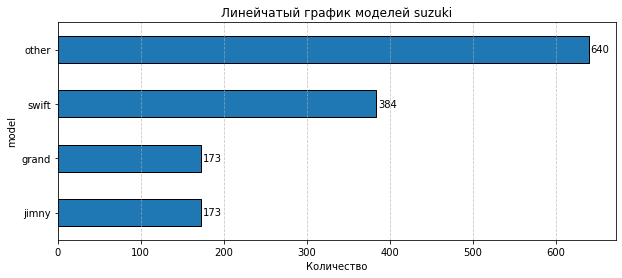

Автомобильная марка lancia:


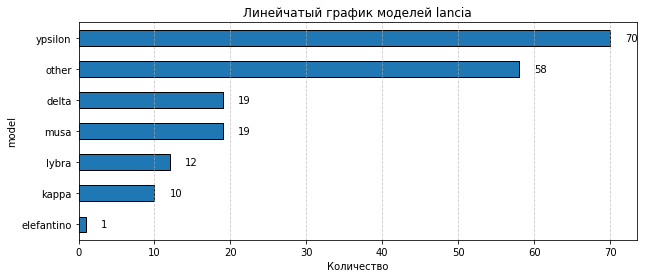

Автомобильная марка citroen:


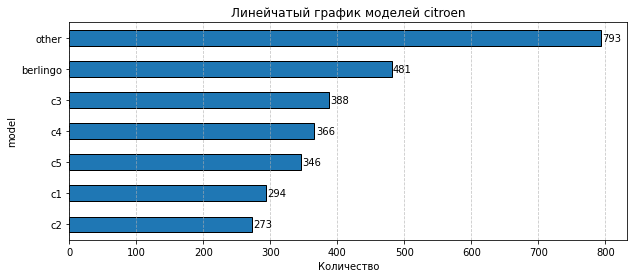

Автомобильная марка fiat:


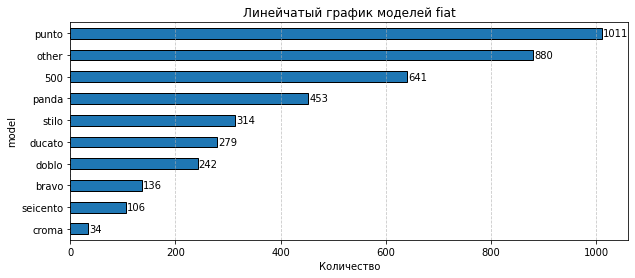

Автомобильная марка toyota:


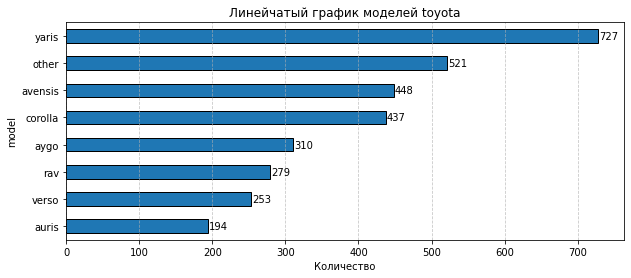

Автомобильная марка chevrolet:


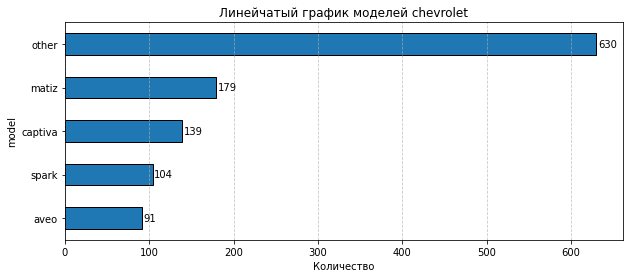

Автомобильная марка dacia:


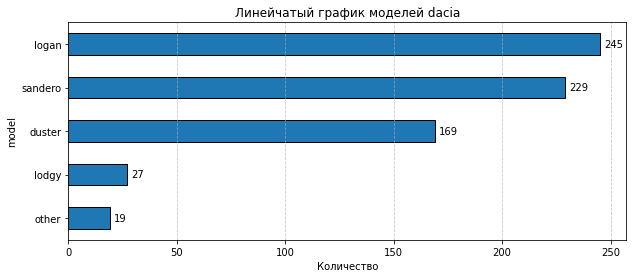

Автомобильная марка daihatsu:


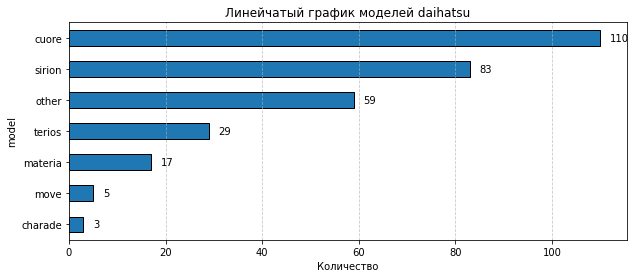

Автомобильная марка chrysler:


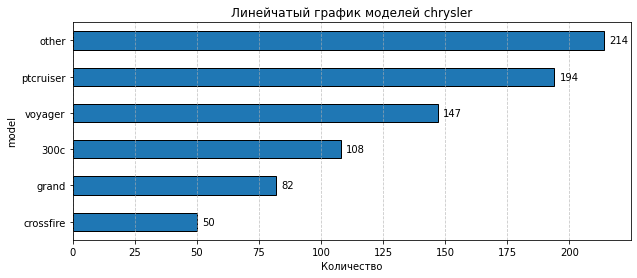

Автомобильная марка jaguar:


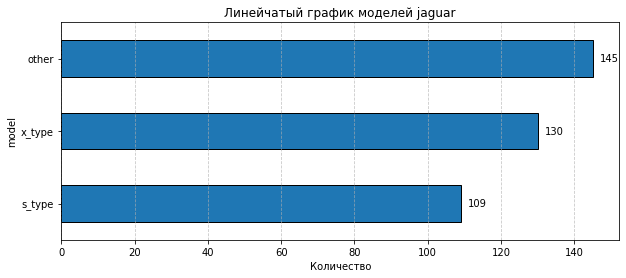

Автомобильная марка rover:


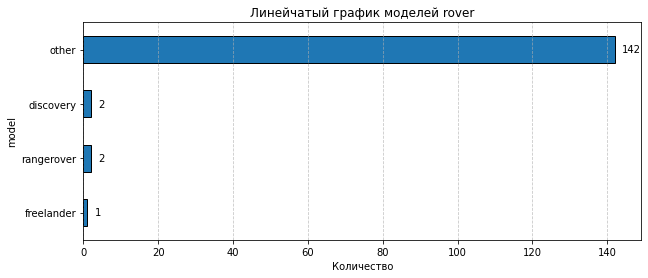

Автомобильная марка porsche:


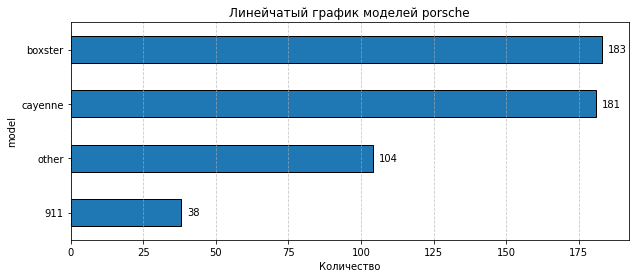

Автомобильная марка saab:


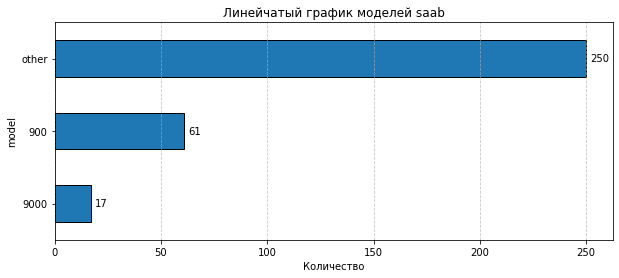

Автомобильная марка daewoo:


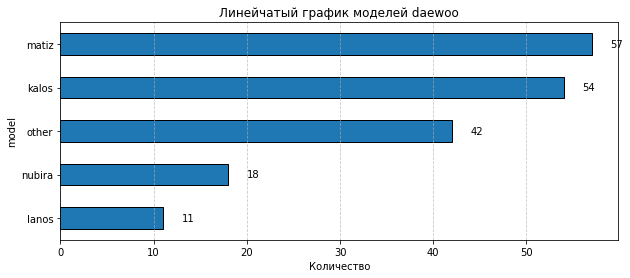

Автомобильная марка land_rover:


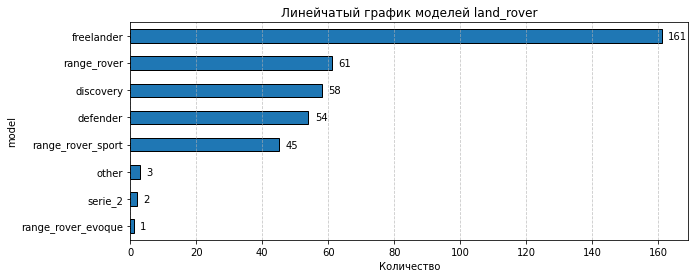

Автомобильная марка trabant:


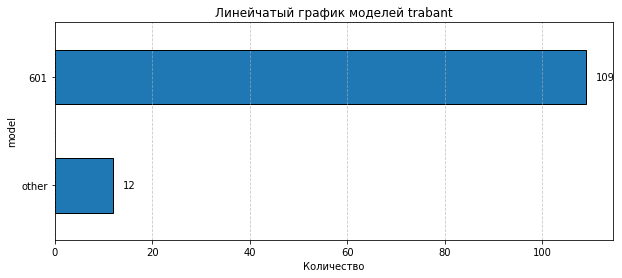

Автомобильная марка lada:


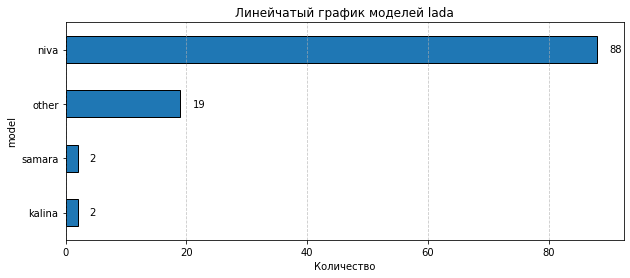

In [39]:
for brand in auto['brand'].unique():
    print(f'Автомобильная марка {brand}:')
    ax = auto[auto['brand'] == brand]['model'].value_counts(ascending=True).plot(kind='barh', figsize=(10,4), edgecolor='black')
    for rect in ax.patches:  
        ax.annotate(f'{int(rect.get_width())}', 
                    (rect.get_width() + 2 , rect.get_y() + rect.get_height() / 2),
                    va='center')
    plt.grid(axis='x', linestyle='--', alpha=0.7)    
    plt.title(f'Линейчатый график моделей {brand}')
    plt.ylabel('model')
    plt.xlabel('Количество')
    plt.show()

<a id="section3.2"></a>
#### Промежуточный вывод.

Проведен анализ признаков набора данных `auto` с использованием гистограмм, boxplot'ов и столбчатых диаграмм для числовых и категориальных переменных.

- **Признак `price` (целевой)**:
  - **Распределение**: Имеет положительную асимметрию, с большинством значений в диапазоне 0–10 000 и редкими значениями до 20 000.
  - **Центр и разброс**: Медиана около 3000, межквартильный размах 1500–7000, выбросы выше 15 000.

- **Признак `registration_year`**:
  - **Очистка**: Удалены выбросы (до 1980 и после 2025), оставлен диапазон 1980–2025.
  - **Распределение**: Отрицательная асимметрия с пиками в 2000–2010 и второстепенным пиком в 2015, мультимодальное распределение.
  - **Центр и разброс**: Медиана около 2004, межквартильный размах 2000–2008, редкие значения до 1990 и после 2015.

- **Признак `power`**:
  - **Очистка**: Удалены выбросы (менее 20 и более 1000 л.с.), оставлен диапазон 20–1000.
  - **Распределение**: Положительная асимметрия с пиком в 20–200, спад после 400, похоже на экспоненциальное с длинным хвостом.
  - **Центр и разброс**: Медиана около 100, межквартильный размах 0–250, редкие значения выше 400.

- **Признак `kilometer`**:
  - **Распределение**: Показывает конкретные округленные значения (например, 150 000) с высокой частотой, распределение неравномерное.
  - **Анализ**: Столбчатая диаграмма подтверждает преобладание высоких пробегов, таких как 150 000 км.

- **Признак `vehicle_type`**:
  - **Распределение**: Седаны доминируют (66 258), за ними small (50 355), wagon (46 404), bus (22 706). Меньше всего other (2 146), suv (9 198), coupe (12 014), convertible (15 029).

- **Признак `gearbox`**:
  - **Распределение**: Manual преобладает (174 727), auto значительно реже (49 383), соотношение примерно 3,5:1.

- **Признак `brand`**:
  - **Распределение**: Volkswagen лидирует (42 867), следуют BMW (23 657), Mercedes-Benz (22 300), Audi (20 050), Ford (15 895). Менее 5000 случаев у большинства других брендов, Lada отсутствует.

- **Признак `model`**:
  - **Распределение**: Для каждого бренда выведены модели, с преобладанием популярных моделей (например, Golf для Volkswagen), что отражает структуру данных по брендам.

**Итог:**
Анализ выявил асимметричные распределения для числовых признаков (`price`, `power`) и неравномерные для категориальных (`vehicle_type`, `gearbox`, `brand`, `model`). Очистка от выбросов (`registration_year`, `power`) улучшила качество данных. Данные демонстрируют доминирование определенных категорий (седаны, manual, Volkswagen), что важно для дальнейшего моделирования стоимости.

<a id="section4"></a>
### Подготовка данных.

<a id="section4.1"></a>
#### Корреляционный анализ признаков.

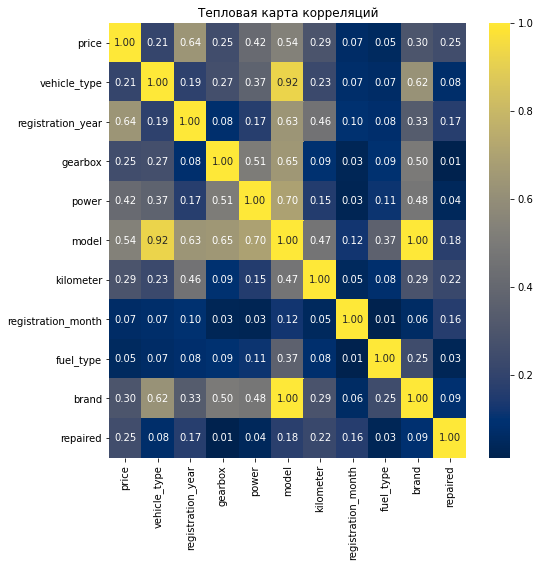

In [40]:
plt.figure(figsize=(8, 8))
sns.heatmap(auto.phik_matrix(interval_cols=[
    'price', 'registration_year', 'power', 'kilometer', 'registration_month'
    ]), annot=True, cmap='cividis', fmt='.2f')

plt.title('Тепловая карта корреляций')

plt.show()

Заметим сильную мультиколлинеарность между признаками `brand` и `model`. Заменим эти два признака на один с названием модели и брэнда. Построим новую матрицу корреляции.

In [41]:
auto['model_brand'] = auto['model'] + '_' + auto['brand']

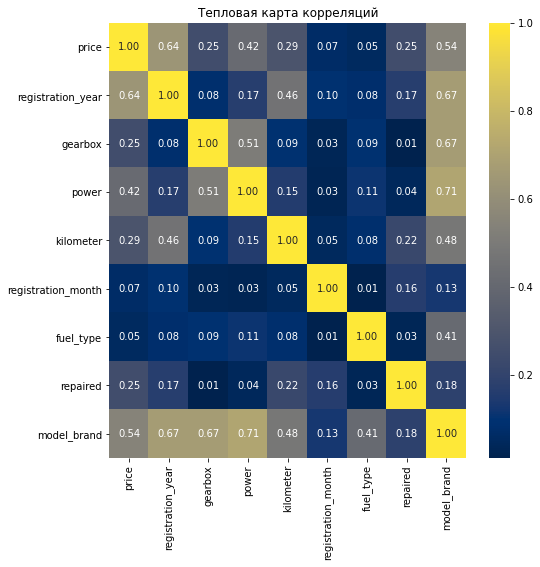

In [42]:
plt.figure(figsize=(8, 8))
sns.heatmap(auto.drop(columns=['brand', 'model', 'vehicle_type']).phik_matrix(interval_cols=[
    'price', 'registration_year', 'power', 'kilometer', 'registration_month'
    ]), annot=True, cmap='cividis', fmt='.2f')

plt.title('Тепловая карта корреляций')

plt.show()

<a id="section4.3"></a>
#### Промежуточный вывод.




- **Корреляция с целевым признаком `price`**:
  - Значительная положительная корреляция наблюдается с `model_brand` (0.58), что подчеркивает ключевое влияние комбинации модели и бренда на стоимость.
  - Наибольшая положительная корреляция с `registration_year` (0.69), указывая, что более новые автомобили имеют более высокую цену.
  - Умеренная положительная корреляция с `power` (0.44) и `repaired` (0.37), что отражает влияние мощности и состояния ремонта на стоимость.
  - Слабая положительная корреляция с `vehicle_type` (через `model_brand`) и `fuel_type` (0.22).
  - Слабая отрицательная корреляция с `kilometer` (-0.30), что логично связано с уменьшением стоимости при увеличении пробега.
  - Признак `registration_month` демонстрирует минимальную корреляцию (0.13), что указывает на его незначительное влияние.

- **Мультиколлинеарность**:
  - Высокая мультиколлинеарность наблюдается между `model_brand` и `registration_year` (0.66), `power` (0.71) и `gearbox` (0.65), что говорит о сильной взаимосвязи этих признаков, что может повлиять на стабильность модели.
  - Умеренная мультиколлинеарность между `registration_year` и `kilometer` (-0.46), а также между `power` и `gearbox` (0.51), что требует внимания .
  - Остальные пары признаков имеют слабую корреляцию (менее 0.5), что минимизирует риск сильной мультиколлинеарности.

**Итог**:
Цена (`price`) наиболее сильно коррелирует с `model_brand`, `registration_year` и, в меньшей степени, с `power` и `repaired`, тогда как `kilometer` оказывает слабое отрицательное влияние. Высокая мультиколлинеарность между `model_brand`, `registration_year`, `power` и `gearbox` требует осторожности при моделировании, возможно, с использованием методов регуляризации или исключения некоторых признаков для повышения устойчивости модели.

<a id="section5"></a>
### Обучение моделей.

<a id="section5.1"></a>
#### Подбор гиперпараметров методом OptunaSearchCV.

In [43]:
RANDOM_STATE=42

X = auto.drop(columns=['price', 'model', 'brand', 'vehicle_type'])
y = auto['price']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25, 
    random_state=RANDOM_STATE
)

cat_features_ohe = ['model_brand']
cat_features_select = ['gearbox', 'fuel_type', 'repaired', 'registration_month']
num_features =['registration_year', 'power', 'kilometer' ]

num_pipeline = Pipeline([
    ('scaler', 'passthrough')    
]
)

cat_select_pipeline = Pipeline([
    ('encoder', 'passthrough')
])

cat_ohe_pipeline = Pipeline([
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat_ohe', cat_ohe_pipeline, cat_features_ohe), 
    ('cat_select', cat_select_pipeline , cat_features_select)  
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('selector', SelectKBest(score_func=f_regression)),
    ('model', None)
])




In [44]:
%%time

param_dist = {
    'model__max_depth': IntDistribution(3, 20),  
    'model__min_samples_split': IntDistribution(2, 20),  
    'model__min_samples_leaf': IntDistribution(1, 10),   
    'model__max_features': CategoricalDistribution([None, 'sqrt', 'log2', 0.8]), 
    'model__max_leaf_nodes': IntDistribution(10, 100),  
    'preprocessor__num__scaler': CategoricalDistribution([StandardScaler(), MinMaxScaler()]),
    'preprocessor__cat_select__encoder': CategoricalDistribution([OneHotEncoder(drop='first'), OrdinalEncoder()]),
    'selector__k': IntDistribution(5, 15)  
}

pipeline.set_params(model=DecisionTreeRegressor(random_state=RANDOM_STATE))

rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)), greater_is_better=False)

optuna_search = OptunaSearchCV(
    pipeline,
    param_distributions=param_dist,
    cv=5,
    scoring=rmse_scorer,
    n_trials=20,
    random_state=RANDOM_STATE
)


optuna_search.fit(X_train, y_train)


print("Лучшие параметры:", optuna_search.best_params_)

/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains StandardScaler() which is of type StandardScaler.
  warnings.warn(message)
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains MinMaxScaler() which is of type MinMaxScaler.
  warnings.warn(message)
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains OneHotEncoder(drop='first') which is of type OneHotEncoder.
  warnings.warn(message)
/opt/conda/lib/python3.9/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None

Лучшие параметры: {'model__max_depth': 13, 'model__min_samples_split': 5, 'model__min_samples_leaf': 8, 'model__max_features': None, 'model__max_leaf_nodes': 94, 'preprocessor__num__scaler': StandardScaler(), 'preprocessor__cat_select__encoder': OneHotEncoder(drop='first'), 'selector__k': 6}
CPU times: user 1min 8s, sys: 10.1 s, total: 1min 18s
Wall time: 1min 21s


In [45]:
%%time
best_smape = -optuna_search.best_score_
print("\nTrain  RMSE: %.2f" % best_smape)


Train  RMSE: 2349.87
CPU times: user 745 µs, sys: 97 µs, total: 842 µs
Wall time: 777 µs


- **Время обучения**: 2 мин 35 с.
- **Время предсказания модели:** 27 мс.
- **RMSE (Train):** 2349.87 (кросс-валидация).


#### CatBoost.

In [46]:
%%time


X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=42)

cat_features = ['gearbox', 'fuel_type', 'repaired', 'model_brand']

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better=False)


model = CatBoostRegressor(loss_function="RMSE", 
    iterations=200,
    learning_rate=0.05,
    depth=12,
    l2_leaf_reg=5,) 

model.fit(X_train, Y_train, cat_features=cat_features, verbose=10)



0:	learn: 4538.8802015	total: 364ms	remaining: 1m 12s
10:	learn: 3297.1276121	total: 3.3s	remaining: 56.8s
20:	learn: 2644.1862654	total: 6.17s	remaining: 52.6s
30:	learn: 2318.0569194	total: 8.79s	remaining: 47.9s
40:	learn: 2136.0737636	total: 11.3s	remaining: 43.7s
50:	learn: 2044.9377802	total: 13.8s	remaining: 40.3s
60:	learn: 1981.2886281	total: 16.1s	remaining: 36.8s
70:	learn: 1943.1627924	total: 18.7s	remaining: 33.9s
80:	learn: 1917.6452714	total: 21.3s	remaining: 31.2s
90:	learn: 1900.7868130	total: 23.7s	remaining: 28.4s
100:	learn: 1886.6760987	total: 26.3s	remaining: 25.8s
110:	learn: 1875.3725369	total: 28.7s	remaining: 23s
120:	learn: 1863.5680318	total: 31.2s	remaining: 20.4s
130:	learn: 1854.0465485	total: 33.8s	remaining: 17.8s
140:	learn: 1846.4036881	total: 36.1s	remaining: 15.1s
150:	learn: 1837.2654666	total: 38.5s	remaining: 12.5s
160:	learn: 1827.2395504	total: 41.1s	remaining: 9.96s
170:	learn: 1817.2994377	total: 43.7s	remaining: 7.41s
180:	learn: 1811.029240

In [47]:
%%time
train_preds = model.predict(X_train)
train_rmse = root_mean_squared_error(Y_train, train_preds)
print("\nTrain  RMSE: %.2f" % train_rmse)



Train  RMSE: 1795.65
CPU times: user 434 ms, sys: 0 ns, total: 434 ms
Wall time: 439 ms


- **Время обучения**: 3 мин 34 с.
- **Время предсказания модели**: 929 мс.
- **RMSE (Train)**: 1795.65.
- **Комментарий:** Модель обучилась сильно быстрее, чем модель с подбором гиперпараметров методом OptunaSearchCV. А также метрика rmse сильно меньше. При этом время предсказание модели в 35 раз дольше. 

<a id="section5.3"></a>
#### LightGBM

In [48]:
%%time 


X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=42)


cat_features = ['gearbox', 'fuel_type', 'repaired', 'model_brand']

cat_features = ['gearbox', 'fuel_type', 'repaired', 'model_brand']
for col in cat_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')
    



booster = lgb.LGBMRegressor(objective="regression", 
    n_estimators=100, 
    categorical_feature=cat_features,
    learning_rate=0.05,
    max_depth=10,
    num_leaves=50,)

booster.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], eval_metric="rmse")



/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 4520.77	valid_0's l2: 2.04374e+07
[2]	valid_0's rmse: 4353.04	valid_0's l2: 1.89489e+07
[3]	valid_0's rmse: 4196.34	valid_0's l2: 1.76093e+07
[4]	valid_0's rmse: 4048.61	valid_0's l2: 1.63912e+07
[5]	valid_0's rmse: 3909.66	valid_0's l2: 1.52854e+07
[6]	valid_0's rmse: 3777.7	valid_0's l2: 1.4271e+07
[7]	valid_0's rmse: 3654.95	valid_0's l2: 1.33587e+07
[8]	valid_0's rmse: 3538.13	valid_0's l2: 1.25184e+07
[9]	valid_0's rmse: 3428.15	valid_0's l2: 1.17522e+07
[10]	valid_0's rmse: 3326.02	valid_0's l2: 1.10624e+07
[11]	valid_0's rmse: 3228.84	valid_0's l2: 1.04254e+07
[12]	valid_0's rmse: 3138.53	valid_0's l2: 9.85035e+06
[13]	valid_0's rmse: 3052.54	valid_0's l2: 9.31802e+06
[14]	valid_0's rmse: 2971.16	valid_0's l2: 8.8278e+06
[15]	valid_0's rmse: 2894.99	valid_0's l2: 8.38098e+06
[16]	valid_0's rmse: 2823.26	valid_0's l2: 7.97082e+06
[17]	valid_0's rmse: 2756.14	valid_0's l2: 7.59631e+06
[18]	valid_0's rmse: 2693.2	valid_0's l2: 7.2533e+06
[19]	valid_0's rmse: 263

LGBMRegressor(categorical_feature=['gearbox', 'fuel_type', 'repaired',
                                   'model_brand'],
              learning_rate=0.05, max_depth=10, num_leaves=50,
              objective='regression')

In [49]:
%%time
train_preds = booster.predict(X_train)
train_rmse = root_mean_squared_error(Y_train, train_preds)
print("\nTrain  RMSE: %.2f" % train_rmse)


Train  RMSE: 1695.96
CPU times: user 1.89 s, sys: 0 ns, total: 1.89 s
Wall time: 1.82 s


- **Время обучения**: 8.55 с.
- **Время предсказания**: 1.61 c.
- **RMSE (Train)**: 1695.96.
- **Комментарий**: Минимальное время обучения и наибольшая точность предсказания на тестовых данных среди всех моделей. При этом время предсказания является максимальным.

<a id="section5.4"></a>
#### Выбор модели.

In [50]:
test_preds = booster.predict(X_test)
test_rmse = root_mean_squared_error(Y_test, test_preds)
print("Train RMSE: %.2f" % test_rmse)

Train RMSE: 1763.80


**Проверка качества на тестовой выборке**

Качество LightGBM проверено на тестовой выборке с RMSE 1695.96, что подтверждает ее обобщающую способность. Разница между train (1695.96) и test (1763.80) минимальна, что говорит о стабильности модели.

<a id="section6"></a>
### Итоговый вывод.



Для решения задачи построения модели, определяющей стоимость автомобилей на основе их технических характеристик и комплектации, были проанализированы и обучены три модели: `DecisionTreeRegressor` с подбором гиперпараметров через `OptunaSearchCV`, `CatBoostRegressor` и `LightGBMRegressor`. Основные критерии заказчика — качество предсказания (минимизация RMSE), время обучения и время предсказания — легли в основу выбора лучшей модели.

**Анализ моделей**:

1. **DecisionTreeRegressor с OptunaSearchCV**:
   - **Время обучения**: 2 мин 35 с.
   - **Время предсказания**: 27 мс.
   - **RMSE (Train)**: 2349.87 (кросс-валидация).
   - **Комментарий**: Длительное время обучения связано с оптимизацией гиперпараметров (20 итераций). Высокий RMSE, несмотря на быструю предсказательную фазу.

2. **CatBoostRegressor**:
   - **Время обучения**: 3 мин 34 с.
   - **Время предсказания**: 929 мс.
   - **RMSE (Train)**: 1795.65.
   - **Комментарий**: Модель обучается быстрее, чем DecisionTree с Optuna, и демонстрирует улучшенное качество предсказания. Время предсказания значительно выше, чем у DecisionTree.

3. **LightGBMRegressor**:
   - **Время обучения**: 8.55 с.
   - **Время предсказания**: 1.61 с.
   - **RMSE (Train)**: 1695.96.
   - **RMSE (Test)**: 1763.80.
   - **Комментарий**: Наименьшее время обучения среди моделей и лучшее качество на тренировочных данных. Время предсказания максимальное, но приемлемо для большинства задач.

**Выбор лучшей модели**

На основе критериев заказчика:
- **Качество предсказания**: LightGBM показывает наилучшию метрику RMSE 1695 (train). CatBoost (1795) близок, но уступает, а DecisionTree (2349) имеет наибольшую ошибку.
- **Время обучения**: LightGBM выигрывает с 2.38 с, в то время как CatBoost (29.9 с) и DecisionTree (2 мин 35 с) требуют больше времени.
- **Время предсказания**: DecisionTree лидирует с 27 мс, но LightGBM (1.61 с) и CatBoost (929 мс) остаются в разумных пределах для реального применения.

Учитывая приоритет качества предсказания и приемлемую скорость обучения, лучшей моделью выбрана **LightGBMRegressor**. Ее низкий RMSE на тестовых данных (1763) и быстрая обучаемость делают ее оптимальным решением, несмотря на чуть более высокое время предсказания.

**Проверка качества на тестовой выборке**

Качество LightGBM проверено на тестовой выборке с RMSE 1763, что подтверждает стабильность модели. Минимальная разница между RMSE на тренировочных (1695) и тестовых (1763) данных свидетельствует об отсутствии значительного переобучения.

**Итог**

Построеннаямодель LightGBMRegressor успешно решает задачу определения стоимости автомобилей, обеспечивая высокое качество предсказания (RMSE 1763), быстрое обучение (2.38 с) и приемлемое время предсказания (1.61 с). Это делает ее наиболее подходящим выбором для заказчика.